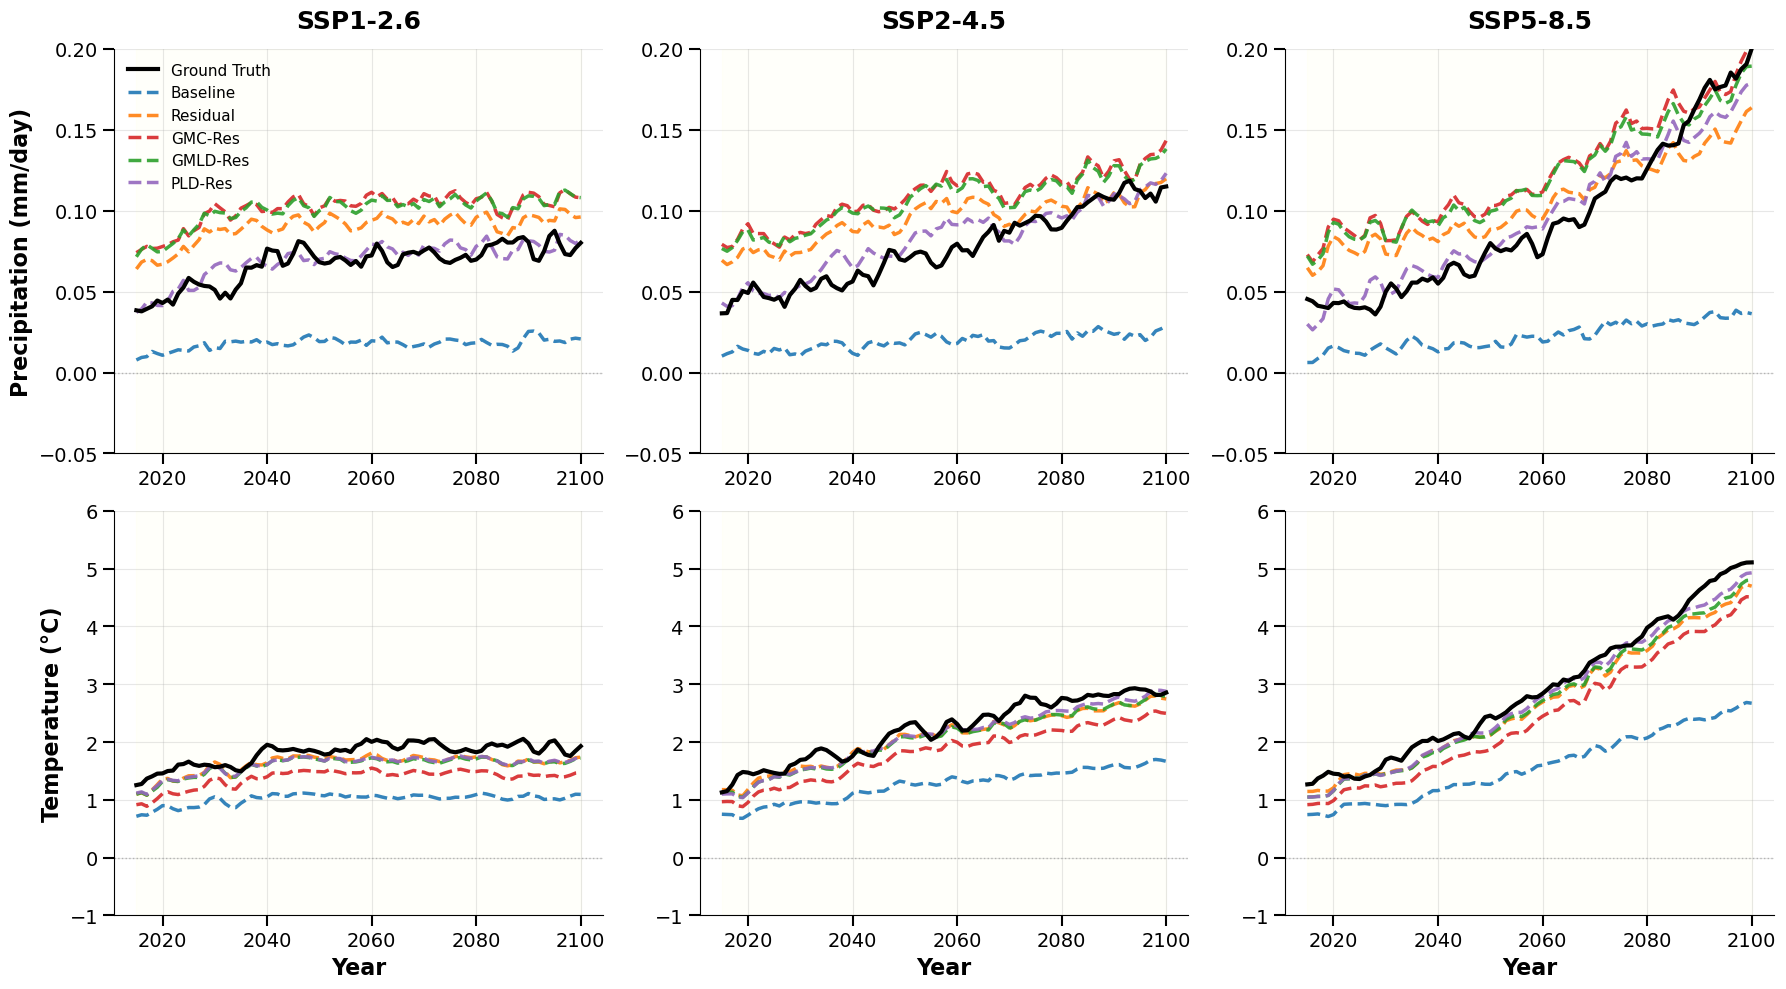

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

# Load original datasets for baseline calculation
data_dir = Path("../data")
ds_hist_orig = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")

# Define time periods for shading
time_periods = [
    (2015, 2100, 'lightyellow', 0.15)  # SSP period only
]

# Scenarios (SSP only)
scenarios = ['ssp126', 'ssp245', 'ssp585']
scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Variables
variables = ['pr', 'tas']
var_labels = {
    'pr': 'Precipitation (mm/day)',
    'tas': 'Temperature (°C)'
}

# Model names and colors
models = ['baseline', 'raw_residual', 'gmc_residual', 'gmld_residual', 'pld_residual']
model_labels = {
    'baseline': 'Baseline',
    'raw_residual': 'Residual',
    'gmc_residual': 'GMC-Res',
    'gmld_residual': 'GMLD-Res',
    'pld_residual': 'PLD-Res'
}
model_colors = {
    'baseline': '#1f77b4',
    'raw_residual': '#ff7f0e',
    'gmc_residual': '#d62728',
    'gmld_residual': '#2ca02c',
    'pld_residual': '#9467bd'
}

# Y-axis configuration
ylim_config = {
    'pr': [(-0.05, 0.20), 0.05],
    'tas': [(-1, 6), 1]
}

def calc_baseline(ds, var, start_year=1850, end_year=1900):
    """Calculate baseline mean for reference period"""
    data = ds[var]
    years = ds.time.dt.year
    mask = (years >= start_year) & (years <= end_year)
    baseline_data = data.isel(time=mask)
    baseline = baseline_data.mean(dim=['time', 'lat', 'lon'])
    return float(baseline.values)

def calc_global_mean(data):
    """Calculate simple global mean"""
    return np.mean(data, axis=(1, 2))

def to_annual_mean(data, time_coords):
    """Convert to annual averages"""
    years = time_coords.dt.year.values
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean to annual data"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Create 2x3 figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for row, var in enumerate(variables):
    var_hr = f"{var}_hr"
    
    # Calculate baseline
    baseline_mean = calc_baseline(ds_hist_orig, var_hr, 1850, 1900)
    
    for col, scenario in enumerate(scenarios):
        ax = axes[row, col]
        time_slice = slice('2015', '2100')
        
        # Load ground truth
        gt_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        
        if gt_file.exists():
            ds_gt = xr.open_dataset(gt_file)
            gt_data = ds_gt['groundtruth'].sel(time=time_slice).values
            time_coords = ds_gt['groundtruth'].sel(time=time_slice).time
            
            # Calculate ground truth statistics
            gt_mean = calc_global_mean(gt_data) - baseline_mean
            years_gt, gt_mean_annual = to_annual_mean(gt_mean, time_coords)
            gt_mean_smooth = smooth_data(gt_mean_annual)
            
            # Plot ground truth
            ax.plot(years_gt, gt_mean_smooth, color='black', 
                   linewidth=3, label='Ground Truth', zorder=10)
        
        # Load and plot model predictions
        for model in models:
            if model == 'baseline':
                pred_file = results_dir / f"{var}_evaluation_{scenario}.nc"
                pred_key = 'pred_zscore_pixel'
            else:
                pred_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
                model_map = {
                    'raw_residual': 'pred_raw',
                    'gmc_residual': 'pred_gma',
                    'gmld_residual': 'pred_gmt',
                    'pld_residual': 'pred_grid'
                }
                pred_key = model_map[model]
            
            if pred_file.exists():
                ds_pred = xr.open_dataset(pred_file)
                if pred_key in ds_pred:
                    pred_data = ds_pred[pred_key].sel(time=time_slice).values
                    pred_mean = calc_global_mean(pred_data) - baseline_mean
                    years_pred, pred_mean_annual = to_annual_mean(pred_mean, time_coords)
                    pred_mean_smooth = smooth_data(pred_mean_annual)
                    
                    ax.plot(years_pred, pred_mean_smooth, 
                           color=model_colors[model], linestyle='--',
                           linewidth=2.5, label=model_labels[model], alpha=0.9)
        
        # Format axes
        for start_year, end_year, color_shade, alpha in time_periods:
            ax.axvspan(start_year, end_year, color=color_shade, alpha=alpha, zorder=0)
        
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        
        # Set y-axis
        ylim, ytick = ylim_config[var]
        ax.set_ylim(ylim)
        ax.set_yticks(np.arange(ylim[0], ylim[1] + ytick/2, ytick))
        
        # Labels
        if row == 0:
            ax.set_title(scenario_labels[scenario], fontsize=18, fontweight='bold', pad=15)
        if col == 0:
            ax.set_ylabel(var_labels[var], fontsize=16, fontweight='bold')
        if row == 1:
            ax.set_xlabel('Year', fontsize=16, fontweight='bold')
        
        # Legend (only on first panel)
        if row == 0 and col == 0:
            ax.legend(loc='best', fontsize=11, frameon=False)
        
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Increase tick parameters
        ax.tick_params(labelsize=14, length=8, width=1.5)

plt.tight_layout()

output_file = figures_dir / "13_temporal_evolution_comparison.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()